In [3]:
%cd /home/vasily/Desktop/research/Model/Rydberg/

/home/vasily/Desktop/research/Model/Rydberg


In [4]:
import numpy as np
import pickle
from time import time
from joblib import Parallel, delayed
import sys
import os
sys.path.append(os.path.abspath('.'))


from src.models.mlp import MLP
from src.eval import RydbergEvaluator
from src.eval.eval_rydberg import est_density_from_z_measurements,determine_phase_1D,est_order_param_1D,phase2img,est_phase_diagram,est_order_param_1D_fourier_from_measurements,est_order_param_1D_fourier,est_order_param_1D_from_measurements
from src.data.loading.dataset_rydberg import RydbergDataset,unif_sample_on_grid


import torch
import pandas as pd
import warnings
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
from tqdm.notebook import tqdm,trange
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from SVMplus import MulticlassSVMplus
import warnings
warnings.filterwarnings('ignore')

from src.utils import plot_phase_diagram

warnings.filterwarnings('ignore')
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [5]:

%cd /home/vasily/Desktop/research/Model/Rydberg/
import os
print(os.getcwd())
os.listdir('src')
# os.listdir('src/models')


/home/vasily/Desktop/research/Model/Rydberg
/home/vasily/Desktop/research/Model/Rydberg


['training',
 'data',
 'models',
 'utils.py',
 '__pycache__',
 '__init__.py',
 'properties',
 'eval']

## Rydberg Data preparation

### H params + Phase

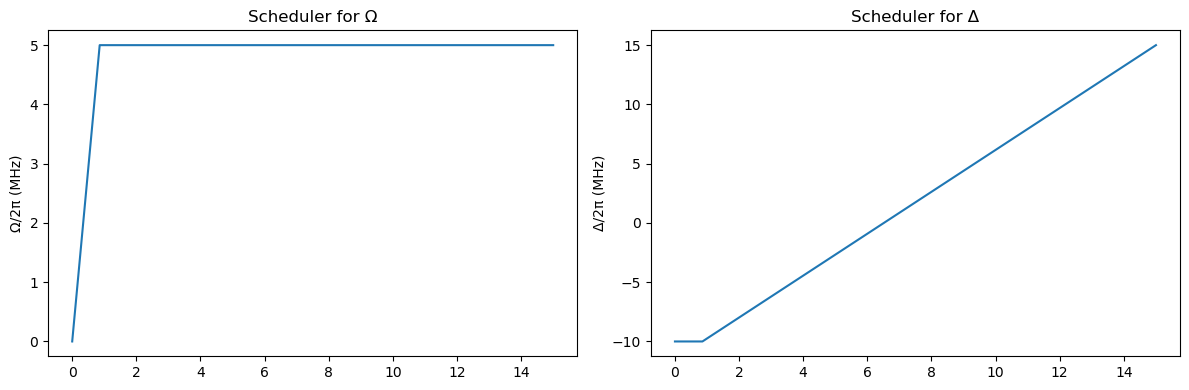

In [6]:

# Here we define a base schedule -- 
base_time = 3.5
ts = np.array([0,0.2,base_time])
omegas = np.array([0, 5, 5])
deltas = np.array([-10, -10, 15])
total_time = 15 # Total adiabatic evolution time of the Bloqade simulation
# We propotionally lengthen the schedules for Omega and Delta by time_ratio = total_time/base_time
time_ratio = total_time/base_time


fig, (ax1, ax2) = plt.subplots(ncols = 2, figsize = (12, 4))
ax1.plot(ts*time_ratio, omegas)
ax1.set_ylabel("Ω/2π (MHz)")
ax1.set_title("Scheduler for Ω")
ax2.plot(ts*time_ratio, deltas)
ax2.set_ylabel("Δ/2π (MHz)")
ax2.set_title("Scheduler for Δ")
fig.tight_layout()

In [7]:
n_qubits = 31 # number of Rydberg atoms in the 1D lattice

dim=1 # dimension of the system
ny = 1 # since we are working in 1D, this variable is fixed to 1
nx = n_qubits # effectively, we are working on a 2D lattice of dimensions nx*ny, where nx=n_qubits and ny=1.
z2_threshold=0.7 # threshold for the Z2 order parameter to determine a state is in Z2 phase
z3_threshold = 0.6 # threshold for the Z3 order parameter to determine a state is in Z3 phase

# We load simulation data for the lattice defined above with the adiabatic evolution scheduler preset above.
folder = f'data/1D-Phase_{nx}/1D-Phase_{nx}/{float(np.round(total_time,2))}µs/'
folder

'data/1D-Phase_31/1D-Phase_31/15.0µs/'

In [8]:
# extra variables we want the conditional generative variable to condition on, except for "nx", "ny", "interaction_range".
# detuning = Delta/Omega
extra_variables = ["detuning",] 
meta_dataset = RydbergDataset(dim=dim,nx = nx, ny=ny, folder=folder,n_threads=1, var_name='interaction_range',variables = extra_variables) 

In [9]:
meta_dataset.est_order_params()
meta_dataset.info["phase" ] = determine_phase_1D(meta_dataset.info["Z2"], meta_dataset.info["Z3"],z2_threshold=z2_threshold,
                                                z3_threshold=z3_threshold
                                            )

In [10]:
def prepare_train_set(meta_dataset, df=None, n_measurements:int = -1, x_bins=10,y_bins=10):
    train_set = {}
    if df is None: df = meta_dataset.info
    train_idxes, train_df = unif_sample_on_grid(df.copy(),x_bins=x_bins,y_bins=y_bins)#,x_range=(0.4,1.78),y_range=(1.4,2.4))
    # train_idxes = plot_df.index.values
    train_keys = meta_dataset.keys[train_idxes]
    train_set.update(meta_dataset.prepare_train_set(train_keys,n_measurements=n_measurements))
    return train_set, train_idxes

In [11]:
load_pretrained = True

if load_pretrained:
    # If loading a pretrained model, we need to also load the training set that 
    # it was trained on (specified by sampled indices of the meta_dataset.info DataFrame)
    train_idxes = np.load('logs/rydberg_1D/train_idxes.npy')
    train_set = pickle.load(open('logs/rydberg_1D/train_set.pkl','rb'))
else:
    # If train from scratch, we sample training data from the phase diagram specified by plot_df
    train_set, train_idxes = prepare_train_set(meta_dataset,df=plot_df)
    ## If you want to save this training set, you can un-comment the following lines:
    # np.save('logs/rydberg_1D/train_idxes.npy',train_idxes)
    # pickle.dump(train_set, open('logs/rydberg_1D/train_set.pkl','wb'))
    # pickle.dump(meta_dataset, open('logs/rydberg_1D/meta_dataset.pkl','wb'))

In [12]:
all_idxes = set(meta_dataset.info.index)
# Get training indexes as a set
train_idxes_set = set(train_idxes)
# Find the rest (test/unused) indexes
rest_idxes = list(all_idxes - train_idxes_set)

data_train = meta_dataset.info.copy().loc[list(train_idxes)]
data_test = meta_dataset.info.copy().loc[rest_idxes]
data_test.describe()


,nx,ny,interaction_range,detuning,Z2,Z3,Z4
count,1460.0,1460.0,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,31.0,1.0,1.998527,0.461099,0.626371,0.447837,0.313278
std,0.0,0.0,0.561743,1.491104,0.162597,0.149372,0.081420
min,31.0,1.0,1.050000,-2.000000,0.486144,0.328892,0.235523
25%,31.0,1.0,1.500000,-0.846154,0.530045,0.373569,0.265820
50%,31.0,1.0,2.000000,0.435897,0.549959,0.382485,0.276429
75%,31.0,1.0,2.500000,1.717949,0.603437,0.442711,0.302999
max,31.0,1.0,2.950000,3.000000,0.984133,0.987812,0.491798


In [13]:
data_train.head()

,nx,ny,interaction_range,detuning,Z2,Z3,Z4,phase
1210,31.0,1.0,2.55,-0.717949,0.546649,0.389260,0.281216,Disordered
891,31.0,1.0,1.50,-0.589744,0.525957,0.376103,0.265038,Disordered
328,31.0,1.0,2.75,-0.974359,0.519552,0.365585,0.263753,Disordered
650,31.0,1.0,1.90,-0.717949,0.524076,0.357881,0.275505,Disordered
88,31.0,1.0,1.15,-0.974359,0.524645,0.365783,0.263551,Disordered


In [14]:
data_train.nunique()

nx                     1
ny                     1
interaction_range     35
detuning              30
Z2                   100
Z3                   100
Z4                   100
phase                  3
dtype: int64

In [15]:
# plot_df = meta_dataset.info.copy()
# plot_df = plot_df.loc[(plot_df['detuning'] >=-1) & (plot_df['interaction_range'] <= 2.8) & (plot_df['interaction_range'] > 1)]
# plot_df

In [16]:
data_train['interaction_range'].sort_values().unique().size, data_train['detuning'].sort_values().unique().size, len(data_train)

(35, 30, 100)

In [17]:
z3_max = data_train[data_train['phase'] == 'Disordered']['Z3'].max()
data_train[data_train['phase'] == 'Disordered'].query('Z3 == @z3_max')

,nx,ny,interaction_range,detuning,Z2,Z3,Z4,phase
995,31.0,1.0,2.7,2.487179,0.554869,0.557616,0.276471,Disordered


In [18]:
data_train.groupby('phase').count()['ny']

phase
Disordered    58
Z2            24
Z3            18
Name: ny, dtype: int64

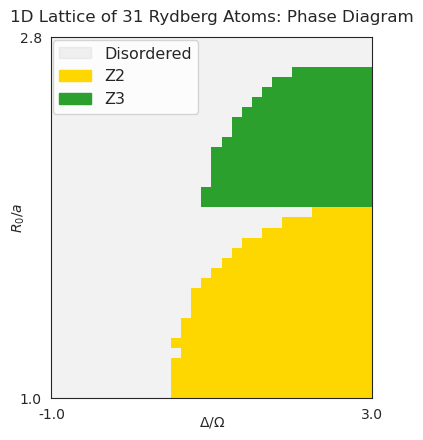

In [19]:
sns.set_style('white')
hue_order = ['Disordered','Z2','Z3']
plot_df = meta_dataset.info.copy()
plot_df = plot_df.loc[(plot_df['detuning'] >=-1) & (plot_df['interaction_range'] <= 2.8) & (plot_df['interaction_range'] > 1)]
fig = plot_phase_diagram(plot_df,title=f"1D Lattice of {n_qubits} Rydberg Atoms: Phase Diagram",hue_order = hue_order,
                        legend=True)

In [20]:
def prepare_dataframe(df): 
    data = df[['interaction_range', 'detuning', 'phase']].rename_axis(columns = {'interaction_range' : 'x', 'detuning': 'y'})
    data['phase'] = data['phase'].apply(lambda x: 0 if x == 'Disordered' else 1 if x == 'Z2' else 2)
    return data[['interaction_range', 'detuning']], data['phase']

X_train, Y_train = prepare_dataframe(data_train)
X_test, Y_test = prepare_dataframe(data_test)

In [21]:
X_train.shape, X_test.shape

((100, 2), (1460, 2))

## Preparing data for kernels, exactly like they did

In [22]:
from src.models.kernels import build_dirichlet_kernel,build_NTK
from sklearn.model_selection import cross_val_score
from sklearn import svm
from sklearn.kernel_ridge import KernelRidge
from sklearn.preprocessing import StandardScaler,MinMaxScaler,Normalizer

2025-08-24 12:47:10.843933: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1756032430.950870   40337 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1756032430.985150   40337 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1756032431.150848   40337 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1756032431.150896   40337 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1756032431.150899   40337 computation_placer.cc:177] computation placer alr

In [23]:
order_params = ['Z2','Z3','Z4']
train_keys = list(train_set.keys())
base_kwargs = {}
Xs,Xs_test,Ys,Ys_test = [],[],[],[]
test_idxes = rest_idxes


for key, measurements in train_set.items():
    x = np.array(key)
    density = np.mean(measurements,axis=0)
    y = [est_order_param_1D_from_measurements(measurements,order_param=order_param,**base_kwargs) for order_param in order_params]
    # y = density
    Xs.append(x)
    Ys.append(y)
Xs,Ys = np.array(Xs),np.array(Ys)

scaler = MinMaxScaler() #Normalizer()
# scaler = StandardScaler()
Xs = scaler.fit_transform(Xs)
Xs_test = scaler.transform(meta_dataset.keys[test_idxes])
Ys_test = meta_dataset.info.loc[test_idxes][order_params].values

In [24]:
test_idxes = np.sort(plot_df.index[~np.isin(plot_df.index,train_idxes)])

In [25]:
def compute_acc(pred_df,true_df,idxes=None):
    if idxes is not None:
        pred_df = pred_df.loc[idxes]
        true_df = true_df.loc[idxes]
    V = pred_df['phase'].values == true_df['phase'].values
    clf_acc = np.mean(V)
    return clf_acc

In [26]:
C_rbf = 4e8
clf_rbf = KernelRidge(kernel='rbf',alpha=1/(2*C_rbf)).fit(Xs,Ys)
# pred_rbf = clf_rbf.predict(Xs_test)
# err_rbf = np.sqrt(np.mean((pred_rbf - Ys_test)**2))

In [27]:
df = plot_df.copy()
# df = df.loc[df[xlabel] > 0]
for order_param in order_params:
    df[order_param] = np.nan
keys = meta_dataset.keys[df.index.values]
xs = scaler.transform(keys)

df[order_params] = clf_rbf.predict(xs)
df['phase'] = determine_phase_1D(df['Z2'].values, df['Z3'].values,z3_threshold=z3_threshold,z2_threshold=z2_threshold)
df = df.sort_values(['phase'])
df_rbf = df.copy()

In [28]:
print('Gaussian Kernel: {:.5f}'.format(compute_acc(df_rbf, plot_df,test_idxes)))

Gaussian Kernel: 0.94901


In [29]:
df_rbf.head()

,nx,ny,interaction_range,detuning,Z2,Z3,Z4,phase
8,31.0,1.0,2.8,-0.974359,0.583180,0.294747,0.305693,Disordered
660,31.0,1.0,1.9,0.564103,0.567754,0.433583,0.286290,Disordered
661,31.0,1.0,1.9,0.692308,0.582039,0.449852,0.293259,Disordered
662,31.0,1.0,1.9,0.820513,0.598418,0.467325,0.301136,Disordered
663,31.0,1.0,1.9,0.948718,0.616453,0.485376,0.309735,Disordered


In [30]:
plot_df.head()

,nx,ny,interaction_range,detuning,Z2,Z3,Z4,phase
8,31.0,1.0,2.8,-0.974359,0.525324,0.369549,0.252004,Disordered
9,31.0,1.0,2.8,-0.846154,0.538451,0.357824,0.277817,Disordered
10,31.0,1.0,2.8,-0.717949,0.516519,0.367392,0.262593,Disordered
11,31.0,1.0,2.8,-0.589744,0.533502,0.390822,0.264082,Disordered
12,31.0,1.0,2.8,-0.461538,0.525716,0.371756,0.247224,Disordered


In [31]:
plot_df['interaction_range'].unique().size, df_rbf['interaction_range'].unique().size

(36, 36)

In [32]:
X_test['interaction_range'].unique().size, X_train['interaction_range'].unique().size

(39, 35)

In [33]:
X_train.tail()

,interaction_range,detuning
598,1.10,2.871795
759,2.40,3.000000
879,2.00,3.000000
78,2.10,2.871795
437,2.25,2.743590


In [34]:
X_train = pd.DataFrame(Xs[:, -2:], columns=['interaction_range', 'detuning'])
X_test = pd.DataFrame(xs[:, -2:], columns=['interaction_range', 'detuning'])

# Privileged information for training
X_star = pd.DataFrame(Ys, columns = ['Z2','Z3','Z4' ])


Y_train = determine_phase_1D(X_star['Z2'].values, X_star['Z3'].values,z3_threshold=z3_threshold,z2_threshold=z2_threshold)
# Y_train = pd.DataFrame(Y_train,columns=['phase'] )
Y_test = plot_df['phase']

### SVM+ where PI = (Z2, Z3, Z4)

In [35]:
# Set random seed for reproducibility (optional)
np.random.seed(19)

# Get the total number of training samples
n_samples = len(X_train)
N_train = 25

# Randomly select N_train indices

random_indices = np.random.choice(n_samples, size=N_train, replace=False)

# Select the same N_train random points from all datasets
X_train = X_train.iloc[random_indices]
X_star = X_star.iloc[random_indices]
Y_train = Y_train[random_indices]  # Assuming Y_train is a numpy array

In [ ]:
def prepare_data(X_train, Y_train, X_test, Y_test, X_star):
    """
    Prepare and standardize the data for training
    """
    # Convert to numpy arrays if they're pandas objects
    X_train_np = X_train.values if hasattr(X_train, 'values') else np.array(X_train)
    X_test_np = X_test.values if hasattr(X_test, 'values') else np.array(X_test)
    X_star_np = X_star.values if hasattr(X_star, 'values') else np.array(X_star)
    Y_train_np = Y_train.values if hasattr(Y_train, 'values') else np.array(Y_train)
    Y_test_np = Y_test.values if hasattr(Y_test, 'values') else np.array(Y_test)
    
    # Standardize features
    scaler_X = StandardScaler()
    scaler_X_star = StandardScaler()
    
    X_train_scaled = scaler_X.fit_transform(X_train_np)
    X_test_scaled = scaler_X.transform(X_test_np)
    X_star_scaled = scaler_X_star.fit_transform(X_star_np)
    
    return X_train_scaled, X_test_scaled, X_star_scaled, Y_train_np, Y_test_np, scaler_X, scaler_X_star

def train_standard_svm(X_train, Y_train, X_test, Y_test):
    """
    Train standard multiclass SVM with hyperparameter tuning
    """
    print("Training Standard SVM...")
    
    # Define parameter grid for grid search
    param_grid = {
        'C': [0.1, 1, 10, 100],
        'gamma': ['scale', 'auto', 0.001, 0.01, 0.1, 1],
        'kernel': ['rbf', 'poly', 'linear']
    }
    
    # Create SVM classifier
    svm = SVC(random_state=42)
    
    # Perform grid search
    grid_search = GridSearchCV(svm, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
    grid_search.fit(X_train, Y_train)
    
    # Get best model
    best_svm = grid_search.best_estimator_
    
    # Make predictions
    y_pred_train = best_svm.predict(X_train)
    y_pred_test = best_svm.predict(X_test)
    
    # Calculate accuracies
    train_accuracy = accuracy_score(Y_train, y_pred_train)
    test_accuracy = accuracy_score(Y_test, y_pred_test)
    
    print(f"Best SVM parameters: {grid_search.best_params_}")
    print(f"Standard SVM - Train Accuracy: {train_accuracy:.4f}")
    print(f"Standard SVM - Test Accuracy: {test_accuracy:.4f}")
    
    return best_svm, y_pred_test, train_accuracy, test_accuracy, grid_search.best_params_

def train_svm_plus(X_train, X_star, Y_train, X_test, Y_test):
    """
    Train SVM+ with hyperparameter tuning
    """
    print("\nTraining SVM+ with Privileged Information...")
    
    # Define parameter grid for SVM+
    param_grid = {
        'C': [0.1, 1, 10, 100],
        'gamma': [0.1, 1, 10, 100],
        'kernel': ['rbf', 'linear'],
        'kernel_star': ['rbf', 'linear']
    }
    
    best_accuracy = 0
    best_params = None
    best_model = None
    
    # Manual grid search for SVM+ (since it doesn't work directly with sklearn's GridSearchCV)
    for C in param_grid['C']:
        for gamma in param_grid['gamma']:
            for kernel in param_grid['kernel']:
                for kernel_star in param_grid['kernel_star']:
                    try:
                        # Create and train SVM+ model
                        svm_plus = MulticlassSVMplus(
                            C=C, gamma=gamma, kernel=kernel, kernel_star=kernel_star,
                            tol=1e-6, max_iter=1000
                        )
                        svm_plus.fit(X_train, X_star, Y_train)
                        
                        # Predict on training set for validation
                        y_pred_train = svm_plus.predict(X_train)
                        train_accuracy = accuracy_score(Y_train, y_pred_train)
                        
                        # Keep track of best model
                        if train_accuracy > best_accuracy:
                            best_accuracy = train_accuracy
                            best_params = {'C': C, 'gamma': gamma, 'kernel': kernel, 'kernel_star': kernel_star}
                            best_model = svm_plus
                            
                    except Exception as e:
                        # Skip parameter combinations that cause errors
                        continue
    
    if best_model is None:
        print("Warning: No SVM+ model could be trained successfully. Using default parameters.")
        best_model = MulticlassSVMplus(C=1.0, gamma=1.0, kernel='rbf', kernel_star='rbf')
        best_model.fit(X_train, X_star, Y_train)
        best_params = {'C': 1.0, 'gamma': 1.0, 'kernel': 'rbf', 'kernel_star': 'rbf'}
    
    # Make predictions
    y_pred_train = best_model.predict(X_train)
    y_pred_test = best_model.predict(X_test)
    
    # Calculate accuracies
    train_accuracy = accuracy_score(Y_train, y_pred_train)
    test_accuracy = accuracy_score(Y_test, y_pred_test)
    
    print(f"Best SVM+ parameters: {best_params}")
    print(f"SVM+ - Train Accuracy: {train_accuracy:.4f}")
    print(f"SVM+ - Test Accuracy: {test_accuracy:.4f}")
    
    return best_model, y_pred_test, train_accuracy, test_accuracy, best_params

def plot_results(svm_train_acc, svm_test_acc, svm_plus_train_acc, svm_plus_test_acc):
    """
    Plot training and test accuracy comparison
    """
    fig, ax = plt.subplots(1, 1, figsize=(8, 5))
    
    # Data for plotting - grouped by accuracy type
    accuracy_types = ['Training Accuracy', 'Test Accuracy']
    svm_accuracies = [svm_train_acc, svm_test_acc]
    svm_plus_accuracies = [svm_plus_train_acc, svm_plus_test_acc]
    
    # Set width of bars and positions
    bar_width = 0.35
    x_pos = np.arange(len(accuracy_types))
    
    # Create bars
    bars1 = ax.bar(x_pos - bar_width/2, svm_accuracies, bar_width, 
                   label='Standard SVM', color='skyblue', alpha=0.8)
    bars2 = ax.bar(x_pos + bar_width/2, svm_plus_accuracies, bar_width,
                   label='SVM+', color='lightgreen', alpha=0.8)
    
    # Customize plot
    ax.set_xlabel('Accuracy Type')
    ax.set_ylabel('Accuracy')
    ax.set_title('Training and Test Accuracy Comparison')
    ax.set_xticks(x_pos)
    ax.set_xticklabels(accuracy_types)
    ax.set_ylim(0, 1.15)  # More free space above columns
    ax.legend()
    
    # Add accuracy values on bars
    for bar, acc in zip(bars1, svm_accuracies):
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02, 
                f'{acc:.3f}', ha='center', va='bottom', fontweight='bold')
    
    for bar, acc in zip(bars2, svm_plus_accuracies):
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02, 
                f'{acc:.3f}', ha='center', va='bottom', fontweight='bold')
    
    plt.tight_layout()
    plt.show()

def generate_detailed_report(Y_test, y_pred_svm, y_pred_svm_plus, 
                           svm_params, svm_plus_params,
                           svm_train_acc, svm_test_acc, 
                           svm_plus_train_acc, svm_plus_test_acc):
    """
    Generate simple comparison report
    """
    print("\n" + "="*50)
    print("RESULTS SUMMARY")
    print("="*50)
    
    print(f"\nStandard SVM Test Accuracy: {svm_test_acc:.3f}")
    print(f"SVM+ Test Accuracy:         {svm_plus_test_acc:.3f}")
    
    improvement = svm_plus_test_acc - svm_test_acc
    print(f"Improvement:                {improvement:+.3f}")
    
    if improvement > 0.01:  # More than 1% improvement
        print(f"\n✓ SVM+ performs better by {improvement*100:.1f}%")
        print("✓ Privileged information is helpful")
    elif improvement < -0.01:  # More than 1% degradation
        print(f"\n✗ SVM+ performs worse by {abs(improvement)*100:.1f}%")
        print("✗ Privileged information is not helpful")
    else:
        print(f"\n≈ Performance is similar (difference < 1%)")
        print("≈ Privileged information has minimal impact")
    
    print(f"\nBest parameters:")
    print(f"  Standard SVM: C={svm_params.get('C', 'N/A')}, kernel={svm_params.get('kernel', 'N/A')}")
    print(f"  SVM+: C={svm_plus_params.get('C', 'N/A')}, gamma={svm_plus_params.get('gamma', 'N/A')}")
    print("="*50)

def main(X_train, Y_train, X_test, Y_test, X_star):
    """
    Main function to run the complete comparison
    """
    print("Comparing Standard SVM vs SVM+ with Privileged Information")
    print("="*55)
    
    # Prepare data
    X_train_scaled, X_test_scaled, X_star_scaled, Y_train_np, Y_test_np, scaler_X, scaler_X_star = prepare_data(
        X_train, Y_train, X_test, Y_test, X_star
    )
    
    print(f"Dataset: {X_train_scaled.shape[0]} train, {X_test_scaled.shape[0]} test samples")
    print(f"Features: {X_train_scaled.shape[1]} regular, {X_star_scaled.shape[1]} privileged")
    print(f"Classes: {len(np.unique(Y_train_np))}")
    
    # Train Standard SVM
    svm_model, y_pred_svm, svm_train_acc, svm_test_acc, svm_params = train_standard_svm(
        X_train_scaled, Y_train_np, X_test_scaled, Y_test_np
    )
    
    # Train SVM+
    svm_plus_model, y_pred_svm_plus, svm_plus_train_acc, svm_plus_test_acc, svm_plus_params = train_svm_plus(
        X_train_scaled, X_star_scaled, Y_train_np, X_test_scaled, Y_test_np
    )
    
    # Simple results report
    generate_detailed_report(
        Y_test_np, y_pred_svm, y_pred_svm_plus,
        svm_params, svm_plus_params,
        svm_train_acc, svm_test_acc,
        svm_plus_train_acc, svm_plus_test_acc
    )
    
    # Plot comparison with both training and test accuracies
    plot_results(svm_train_acc, svm_test_acc, svm_plus_train_acc, svm_plus_test_acc)
    
    return {
        'svm_accuracy': svm_test_acc,
        'svm_plus_accuracy': svm_plus_test_acc,
        'improvement': svm_plus_test_acc - svm_test_acc,
        'models': {'svm': svm_model, 'svm_plus': svm_plus_model}
    }

def get_overall_results(data_all, N_train, N_seeds ):
    seeds = np.random.randint(1, 1000, N_seeds)
    # n_samples = len(X_train)

    # Computing the average accuracy for N_train training data points randomly chosen 
    # from the data_all, averaging is over N_seeds points 

def plot_overall_results(data_all):

    svm_acc_stat = []
    svmplus_acc_stat = []
    improvements = []

    N_train_points = [i for i in range(20,120,10)]
    N_seeds = 10

    for N_train in N_train_points:

        svm_acc_stat.append(get_overall_results(data_all, N_train, N_seeds))
        svmplus_acc_stat.append()
        improvements.append()

        # plotting the results


        

    
    return 

In [39]:
[i for i in range(20,120,10)]

[20, 30, 40, 50, 60, 70, 80, 90, 100, 110]

Comparing Standard SVM vs SVM+ with Privileged Information
Dataset: 25 train, 1152 test samples
Features: 2 regular, 3 privileged
Classes: 3
Training Standard SVM...
Best SVM parameters: {'C': 10, 'gamma': 1, 'kernel': 'rbf'}
Standard SVM - Train Accuracy: 1.0000
Standard SVM - Test Accuracy: 0.8628

Training SVM+ with Privileged Information...
Best SVM+ parameters: {'C': 1, 'gamma': 0.1, 'kernel': 'rbf', 'kernel_star': 'rbf'}
SVM+ - Train Accuracy: 1.0000
SVM+ - Test Accuracy: 0.8307

RESULTS SUMMARY

Standard SVM Test Accuracy: 0.863
SVM+ Test Accuracy:         0.831
Improvement:                -0.032

✗ SVM+ performs worse by 3.2%
✗ Privileged information is not helpful

Best parameters:
  Standard SVM: C=10, kernel=rbf
  SVM+: C=1, gamma=0.1


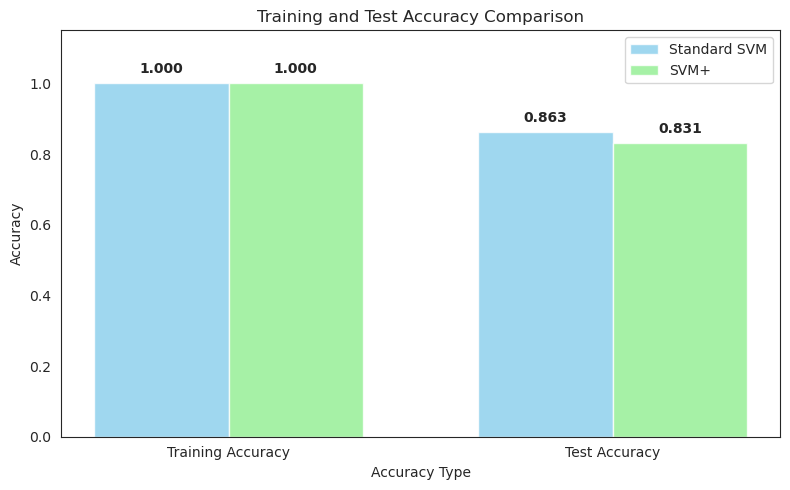

Standard SVM: 0.863
SVM+:         0.831
Improvement:  -0.032


In [37]:
# Simple Usage Example

# Run the comparison with your data:
results = main(X_train, Y_train, X_test, Y_test, X_star)

# results = main(Xs,Xs_test,Ys,Ys_test,X_star)

# Get the key results:
print(f"Standard SVM: {results['svm_accuracy']:.3f}")
print(f"SVM+:         {results['svm_plus_accuracy']:.3f}")
print(f"Improvement:  {results['improvement']:+.3f}")

In [38]:
# seeds = np.random.randint(1, 100, 10)
seeds = [i for i in range(9,20)]
n_samples = len(X_train)
N_train = 25


svm_acc_stat = []
svmplus_acc_stat = []
improvements = []


for seed in seeds: 
    np.random.seed(seed)
    random_indices = np.random.choice(n_samples, size=N_train, replace=False)

    X_train = pd.DataFrame(Xs[:, -2:], columns=['interaction_range', 'detuning'])
    X_test = pd.DataFrame(xs[:, -2:], columns=['interaction_range', 'detuning'])

    # Privileged information for training
    X_star = pd.DataFrame(Ys, columns = ['Z2','Z3','Z4' ])


    Y_train = determine_phase_1D(X_star['Z2'].values, X_star['Z3'].values,z3_threshold=z3_threshold,z2_threshold=z2_threshold)
    Y_test = plot_df['phase']

    X_train = X_train.iloc[random_indices]
    X_star = X_star.iloc[random_indices]
    Y_train = Y_train[random_indices]  


    # Run the comparison with your data:
    results = main(X_train, Y_train, X_test, Y_test, X_star)
    svm_acc_stat.append(results['svm_accuracy'])
    svmplus_acc_stat.append(results['svm_plus_accuracy'])
    improvements.append(results['improvement'])

print("Standard SVM : ", svm_acc_stat)
print("Standard SVM+ : ", svmplus_acc_stat)
print(improvements)


Comparing Standard SVM vs SVM+ with Privileged Information
Dataset: 25 train, 1152 test samples
Features: 2 regular, 3 privileged
Classes: 1
Training Standard SVM...


ValueError: 
All the 360 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
360 fits failed with the following error:
Traceback (most recent call last):
  File "/home/vasily/miniconda3/envs/my_env/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/vasily/miniconda3/envs/my_env/lib/python3.12/site-packages/sklearn/base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/vasily/miniconda3/envs/my_env/lib/python3.12/site-packages/sklearn/svm/_base.py", line 207, in fit
    y = self._validate_targets(y)
        ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/vasily/miniconda3/envs/my_env/lib/python3.12/site-packages/sklearn/svm/_base.py", line 751, in _validate_targets
    raise ValueError(
ValueError: The number of classes has to be greater than one; got 1 class


In [ ]:
results

{'svm_accuracy': 0.7387152777777778,
 'svm_plus_accuracy': 0.8394097222222222,
 'improvement': 0.10069444444444442,
 'models': {'svm': SVC(C=10, gamma=1, kernel='poly', random_state=42),
  'svm_plus': MulticlassSVMplus(C=10, gamma=0.1, kernel_params={}, kernel_star_params={})}}

In [ ]:
subset_results = evaluate_multiple_subsets(
    X_train_full=X_train,
    Y_train_full=Y_train, 
    X_test=X_test,
    Y_test=Y_test,
    X_star_full=X_star,
    N_train=25,
    n_iterations=10
)

Evaluating 10 random subsets of 25 training samples each...

Iteration 1/10
------------------------------
Comparing Standard SVM vs SVM+ with Privileged Information
Dataset: 25 train, 1152 test samples
Features: 2 regular, 3 privileged
Classes: 3
Training Standard SVM...
Best SVM parameters: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
Standard SVM - Train Accuracy: 0.9600
Standard SVM - Test Accuracy: 0.8594

Training SVM+ with Privileged Information...


KeyboardInterrupt: 

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
# Import the SVMdelta+ classes
from SVMdeltaplus import MulticlassSVMdeltaplus

def prepare_data(X_train, Y_train, X_test, Y_test, X_star):
    """
    Prepare and standardize the data for training
    """
    # Convert to numpy arrays if they're pandas objects
    X_train_np = X_train.values if hasattr(X_train, 'values') else np.array(X_train)
    X_test_np = X_test.values if hasattr(X_test, 'values') else np.array(X_test)
    X_star_np = X_star.values if hasattr(X_star, 'values') else np.array(X_star)
    Y_train_np = Y_train.values if hasattr(Y_train, 'values') else np.array(Y_train)
    Y_test_np = Y_test.values if hasattr(Y_test, 'values') else np.array(Y_test)
    
    # Standardize features
    scaler_X = StandardScaler()
    scaler_X_star = StandardScaler()
    
    X_train_scaled = scaler_X.fit_transform(X_train_np)
    X_test_scaled = scaler_X.transform(X_test_np)
    X_star_scaled = scaler_X_star.fit_transform(X_star_np)
    
    return X_train_scaled, X_test_scaled, X_star_scaled, Y_train_np, Y_test_np, scaler_X, scaler_X_star

def train_standard_svm(X_train, Y_train, X_test, Y_test):
    """
    Train standard multiclass SVM with hyperparameter tuning
    """
    print("Training Standard SVM...")
    
    # Define parameter grid for grid search
    param_grid = {
        'C': [0.1, 1, 10, 100],
        'gamma': ['scale', 'auto', 0.001, 0.01, 0.1, 1],
        'kernel': ['rbf', 'poly', 'linear']
    }
    
    # Create SVM classifier
    svm = SVC(random_state=42)
    
    # Perform grid search
    grid_search = GridSearchCV(svm, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
    grid_search.fit(X_train, Y_train)
    
    # Get best model
    best_svm = grid_search.best_estimator_
    
    # Make predictions
    y_pred_train = best_svm.predict(X_train)
    y_pred_test = best_svm.predict(X_test)
    
    # Calculate accuracies
    train_accuracy = accuracy_score(Y_train, y_pred_train)
    test_accuracy = accuracy_score(Y_test, y_pred_test)
    
    print(f"Best SVM parameters: {grid_search.best_params_}")
    print(f"Standard SVM - Train Accuracy: {train_accuracy:.4f}")
    print(f"Standard SVM - Test Accuracy: {test_accuracy:.4f}")
    
    return best_svm, y_pred_test, train_accuracy, test_accuracy, grid_search.best_params_

def train_svmdelta_plus(X_train, X_star, Y_train, X_test, Y_test):
    """
    Train SVMdelta+ with hyperparameter tuning
    """
    print("\nTraining SVMdelta+ with Privileged Information and Similarity Control...")
    
    # Define parameter grid for SVMdelta+
    param_grid = {
        'C': [0.1, 1, 10, 100],
        'gamma': [0.1, 1, 10, 100],
        'delta': [0.01, 0.1, 1, 10],  # New parameter for similarity control
        'kernel': ['rbf', 'linear'],
        'kernel_star': ['rbf', 'linear'],
        'similarity_type': ['linear', 'quadratic']  # New parameter for similarity type
    }
    
    best_accuracy = 0
    best_params = None
    best_model = None
    
    print("Searching for optimal hyperparameters...")
    total_combinations = (len(param_grid['C']) * len(param_grid['gamma']) * 
                         len(param_grid['delta']) * len(param_grid['kernel']) * 
                         len(param_grid['kernel_star']) * len(param_grid['similarity_type']))
    print(f"Testing {total_combinations} parameter combinations...")
    
    current_combination = 0
    
    # Manual grid search for SVMdelta+ (since it doesn't work directly with sklearn's GridSearchCV)
    for C in param_grid['C']:
        for gamma in param_grid['gamma']:
            for delta in param_grid['delta']:
                for kernel in param_grid['kernel']:
                    for kernel_star in param_grid['kernel_star']:
                        for similarity_type in param_grid['similarity_type']:
                            current_combination += 1
                            if current_combination % 20 == 0:
                                progress = (current_combination / total_combinations) * 100
                                print(f"Progress: {progress:.1f}% ({current_combination}/{total_combinations})")
                            
                            try:
                                # Create and train SVMdelta+ model
                                svmdelta_plus = MulticlassSVMdeltaplus(
                                    C=C, gamma=gamma, delta=delta,
                                    kernel=kernel, kernel_star=kernel_star,
                                    similarity_type=similarity_type,
                                    tol=1e-6, max_iter=1000
                                )
                                svmdelta_plus.fit(X_train, X_star, Y_train)
                                
                                # Predict on training set for validation
                                y_pred_train = svmdelta_plus.predict(X_train)
                                train_accuracy = accuracy_score(Y_train, y_pred_train)
                                
                                # Keep track of best model
                                if train_accuracy > best_accuracy:
                                    best_accuracy = train_accuracy
                                    best_params = {
                                        'C': C, 'gamma': gamma, 'delta': delta,
                                        'kernel': kernel, 'kernel_star': kernel_star,
                                        'similarity_type': similarity_type
                                    }
                                    best_model = svmdelta_plus
                                    
                            except Exception as e:
                                # Skip parameter combinations that cause errors
                                continue
    
    if best_model is None:
        print("Warning: No SVMdelta+ model could be trained successfully. Using default parameters.")
        best_model = MulticlassSVMdeltaplus(
            C=1.0, gamma=1.0, delta=1.0,
            kernel='rbf', kernel_star='rbf',
            similarity_type='linear'
        )
        best_model.fit(X_train, X_star, Y_train)
        best_params = {
            'C': 1.0, 'gamma': 1.0, 'delta': 1.0,
            'kernel': 'rbf', 'kernel_star': 'rbf',
            'similarity_type': 'linear'
        }
    
    # Make predictions
    y_pred_train = best_model.predict(X_train)
    y_pred_test = best_model.predict(X_test)
    
    # Calculate accuracies
    train_accuracy = accuracy_score(Y_train, y_pred_train)
    test_accuracy = accuracy_score(Y_test, y_pred_test)
    
    print(f"\nBest SVMdelta+ parameters: {best_params}")
    print(f"SVMdelta+ - Train Accuracy: {train_accuracy:.4f}")
    print(f"SVMdelta+ - Test Accuracy: {test_accuracy:.4f}")
    
    return best_model, y_pred_test, train_accuracy, test_accuracy, best_params

def plot_results(svm_train_acc, svm_test_acc, svmdelta_plus_train_acc, svmdelta_plus_test_acc):
    """
    Plot training and test accuracy comparison
    """
    fig, ax = plt.subplots(1, 1, figsize=(10, 6))
    
    # Data for plotting - grouped by accuracy type
    accuracy_types = ['Training Accuracy', 'Test Accuracy']
    svm_accuracies = [svm_train_acc, svm_test_acc]
    svmdelta_plus_accuracies = [svmdelta_plus_train_acc, svmdelta_plus_test_acc]
    
    # Set width of bars and positions
    bar_width = 0.35
    x_pos = np.arange(len(accuracy_types))
    
    # Create bars
    bars1 = ax.bar(x_pos - bar_width/2, svm_accuracies, bar_width, 
                   label='Standard SVM', color='skyblue', alpha=0.8)
    bars2 = ax.bar(x_pos + bar_width/2, svmdelta_plus_accuracies, bar_width,
                   label='SVMδ+', color='lightgreen', alpha=0.8)
    
    # Customize plot
    ax.set_xlabel('Accuracy Type')
    ax.set_ylabel('Accuracy')
    ax.set_title('Training and Test Accuracy Comparison: Standard SVM vs SVMδ+')
    ax.set_xticks(x_pos)
    ax.set_xticklabels(accuracy_types)
    ax.set_ylim(0, 1.15)  # More free space above columns
    ax.legend()
    
    # Add accuracy values on bars
    for bar, acc in zip(bars1, svm_accuracies):
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02, 
                f'{acc:.3f}', ha='center', va='bottom', fontweight='bold')
    
    for bar, acc in zip(bars2, svmdelta_plus_accuracies):
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02, 
                f'{acc:.3f}', ha='center', va='bottom', fontweight='bold')
    
    plt.tight_layout()
    plt.show()

def generate_detailed_report(Y_test, y_pred_svm, y_pred_svmdelta_plus, 
                           svm_params, svmdelta_plus_params,
                           svm_train_acc, svm_test_acc, 
                           svmdelta_plus_train_acc, svmdelta_plus_test_acc):
    """
    Generate detailed comparison report for SVMdelta+
    """
    print("\n" + "="*65)
    print("RESULTS SUMMARY: Standard SVM vs SVMδ+ (Similarity Control)")
    print("="*65)
    
    print(f"\nStandard SVM Test Accuracy:     {svm_test_acc:.3f}")
    print(f"SVMδ+ Test Accuracy:            {svmdelta_plus_test_acc:.3f}")
    
    improvement = svmdelta_plus_test_acc - svm_test_acc
    print(f"Improvement:                    {improvement:+.3f}")
    
    if improvement > 0.01:  # More than 1% improvement
        print(f"\n✓ SVMδ+ performs better by {improvement*100:.1f}%")
        print("✓ Privileged information with similarity control is helpful")
        print("✓ The learned similarity measure improves classification")
    elif improvement < -0.01:  # More than 1% degradation
        print(f"\n✗ SVMδ+ performs worse by {abs(improvement)*100:.1f}%")
        print("✗ Privileged information with similarity control is not helpful")
        print("✗ The similarity transformation may be introducing noise")
    else:
        print(f"\n≈ Performance is similar (difference < 1%)")
        print("≈ Privileged information has minimal impact")
        print("≈ Consider different delta or similarity_type values")
    
    # Additional insights about SVMdelta+ specific parameters
    delta = svmdelta_plus_params.get('delta', 'N/A')
    similarity_type = svmdelta_plus_params.get('similarity_type', 'N/A')
    
    print(f"\nSimilarity Control Analysis:")
    print(f"  Best delta parameter: {delta}")
    print(f"  Best similarity type: {similarity_type}")
    
    if delta != 'N/A':
        if delta < 0.1:
            print("  → Low delta: Weak similarity control, close to standard SVM")
        elif delta > 10:
            print("  → High delta: Strong similarity control, heavily privileged-dependent")
        else:
            print("  → Moderate delta: Balanced similarity control")
    
    if similarity_type == 'linear':
        print("  → Linear similarity: Uses exponential distance-based transformation")
    elif similarity_type == 'quadratic':
        print("  → Quadratic similarity: Uses normalized kernel-based transformation")
    
    print(f"\nBest parameters:")
    print(f"  Standard SVM:")
    print(f"    C={svm_params.get('C', 'N/A')}, kernel={svm_params.get('kernel', 'N/A')}")
    print(f"  SVMδ+:")
    print(f"    C={svmdelta_plus_params.get('C', 'N/A')}, gamma={svmdelta_plus_params.get('gamma', 'N/A')}")
    print(f"    delta={delta}, similarity={similarity_type}")
    print(f"    kernel={svmdelta_plus_params.get('kernel', 'N/A')}, kernel*={svmdelta_plus_params.get('kernel_star', 'N/A')}")
    print("="*65)

def main(X_train, Y_train, X_test, Y_test, X_star):
    """
    Main function to run the complete comparison between Standard SVM and SVMdelta+
    """
    print("Comparing Standard SVM vs SVMδ+ with Privileged Information and Similarity Control")
    print("="*80)
    
    # Prepare data
    X_train_scaled, X_test_scaled, X_star_scaled, Y_train_np, Y_test_np, scaler_X, scaler_X_star = prepare_data(
        X_train, Y_train, X_test, Y_test, X_star
    )
    
    print(f"Dataset: {X_train_scaled.shape[0]} train, {X_test_scaled.shape[0]} test samples")
    print(f"Features: {X_train_scaled.shape[1]} regular, {X_star_scaled.shape[1]} privileged")
    print(f"Classes: {len(np.unique(Y_train_np))}")
    print(f"Note: SVMδ+ uses privileged features to learn similarity control")
    
    # Train Standard SVM
    svm_model, y_pred_svm, svm_train_acc, svm_test_acc, svm_params = train_standard_svm(
        X_train_scaled, Y_train_np, X_test_scaled, Y_test_np
    )
    
    # Train SVMdelta+
    svmdelta_plus_model, y_pred_svmdelta_plus, svmdelta_plus_train_acc, svmdelta_plus_test_acc, svmdelta_plus_params = train_svmdelta_plus(
        X_train_scaled, X_star_scaled, Y_train_np, X_test_scaled, Y_test_np
    )
    
    # Generate detailed comparison report
    generate_detailed_report(
        Y_test_np, y_pred_svm, y_pred_svmdelta_plus,
        svm_params, svmdelta_plus_params,
        svm_train_acc, svm_test_acc,
        svmdelta_plus_train_acc, svmdelta_plus_test_acc
    )
    
    # Plot comparison with both training and test accuracies
    plot_results(svm_train_acc, svm_test_acc, svmdelta_plus_train_acc, svmdelta_plus_test_acc)
    
    return {
        'svm_accuracy': svm_test_acc,
        'svmdelta_plus_accuracy': svmdelta_plus_test_acc,
        'improvement': svmdelta_plus_test_acc - svm_test_acc,
        'similarity_params': {
            'delta': svmdelta_plus_params.get('delta', None),
            'similarity_type': svmdelta_plus_params.get('similarity_type', None)
        },
        'models': {'svm': svm_model, 'svmdelta_plus': svmdelta_plus_model}
    }

In [ ]:
# Same usage as before, but now with SVMdelta+
# results = main(X_train, Y_train, X_test, Y_test, X_star)

# Results now include similarity control analysis
print(f"Similarity type used: {results['similarity_params']['similarity_type']}")
print(f"Delta parameter: {results['similarity_params']['delta']}")

KeyError: 'similarity_params'

Decision boundaries for all pairs of classes, probability for each calss on phase diagram 
Advantage if the prob. are close to the true (or any) decision boundary

**Theorem:** Assume $\text{BQP} \neq \text{BPP}$. Let $\mathcal{H} = \{H(\mathbf{x}) : \mathbf{x} \in \mathbb{R}^m\}$ be a family of local Hamiltonians on $n$ qubits parametrized by an $m$-dimensional vector $\mathbf{x}$ of Hamiltonian parameters, with ground states $|\psi(\mathbf{x})\rangle$. Any classical algorithm $\mathcal{A}$ that, for arbitrary local observables $O$, can predict $\langle\psi(\mathbf{x})|O|\psi(\mathbf{x})\rangle$ across **all possible** quantum phase transitions in $\mathcal{H}$ either:

1. **Exponential Sample Complexity**: Requires training data with sample complexity $\Omega(2^{f(n)})$ for some $f(n) = \omega(\log n)$, or
2. **Failure on Hard Instances**: Fails on at least one phase transition involving QMA-hard ground state properties



**Proof Strategy:**

**Step 1 - Hard Instance Construction:**
Construct Hamiltonian family 
$$H(\mathbf{x}) = (1-x_m) H_{\text{easy}} + x_m H_{\text{hard}}(\mathbf{x}_{1:m-1})$$
where $H_{\text{easy}} = \sum_i |0\rangle\langle 0|_i$ and $H_{\text{hard}}$ encodes QMA-complete problems.

**Step 2 - Information-Theoretic Lower Bound:**
- Hard phase ground states require $\Omega(2^{\text{poly}(n)})$ classical bits to describe
- Parameter space discretization yields $\mathcal{O}((1/\delta)^m)$ grid points in hard region
- Total information needed: $\mathcal{O}((1/\delta)^m \cdot 2^{\text{poly}(n)})$ bits
- Classical measurements provide: $\text{poly}(n,m) \cdot k$ bits
- Gap is exponential in $n$

**Step 3 - Reduction to QMA:**
If algorithm $\mathcal{A}$ succeeds, construct oracle for QMA-complete Local Hamiltonian problem:
$$\text{Input: } H_{\text{instance}}$$
$$\text{Set: } \mathbf{x}^* = (0,\ldots,0,1) \text{ so that } H(\mathbf{x}^*) = H_{\text{instance}}$$
$$\text{Query: } \mathcal{A}(\mathbf{x}^*, O_{\text{energy}}) \text{ to get } \langle H_{\text{instance}} \rangle$$
$$\text{Solve: } \text{QMA problem from energy estimation}$$

**Step 4 - Complexity Collapse:**
Success of oracle implies $\text{QMA} \subseteq \text{BPP}$, but:
$$\text{BQP} \subseteq \text{QMA} \subseteq \text{BPP}$$
contradicts $\text{BQP} \neq \text{BPP}$.

**Conclusion:** Either the algorithm uses exponential samples (1) or fails on QMA-hard instances (2). $\square$

### Shadows data

In [ ]:
data.head()

NameError: name 'data' is not defined

In [ ]:
data_keys = list(train_set.keys())
H_params = [(k[2], k[3]) for k in data_keys]
H_params[:3]

[(np.float64(1.1), np.float64(-0.8461538461538459)),
 (np.float64(1.25), np.float64(-0.8461538461538459)),
 (np.float64(1.6), np.float64(-0.8461538461538459))]

In [ ]:
train_set[data_keys[0]]

array([[False, False,  True, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False,  True, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

In [ ]:
len(train_set.keys()), len(train_idxes)

(100, 50)

In [ ]:
train_set[list(train_set.keys())[0]].shape, len(list(train_set.keys()))

((1000, 31), 100)

## Simple NN to learn Rydberg phases

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from sklearn.preprocessing import StandardScaler

In [ ]:
class Net(nn.Module):
    def __init__(self,d,q):
        super(Net, self).__init__()
        self.hidden1 = nn.Linear(d,16)
        self.hidden2 = nn.Linear(16,32)
        self.dp1     = nn.Dropout2d(p=0.2)
        self.dp2     = nn.Dropout2d(p=0.2)
        self.out = nn.Linear(32,q)

    def forward(self,x):
        x = x.view(x.size(0), -1)
        x = self.dp1(F.relu(self.hidden1(x)))
        x = self.dp2(F.relu(self.hidden2(x)))
        x = F.softmax(self.out(x))
        return x
    
def fitModel(model,optimizer,criterion,epochs,x,target):
    for _ in range(epochs):
            # Forward pass: Compute predicted y by passing x to the model
        y_pred = model(x)
        # Compute and print loss
        loss = criterion(y_pred, target)
        #print(epoch, loss.data[0])
        # Zero gradients, perform a backward pass, and update the weights.
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    return model

In [ ]:
Y_train.unique().size

3

In [ ]:
epochs=50
criterion = torch.nn.CrossEntropyLoss()

priv=[]
dist=[]
t=0.6
l=1

def model_estimation(X_train, Y_train, X_test, Y_test):

    reg=[]

    for _ in range(10):
        n_features = X_train.shape[1]
        m_labels = Y_train.unique().size
        x_tr = Variable(torch.from_numpy(X_train.values)).type(torch.FloatTensor)
        y_tr = Variable(torch.from_numpy(Y_train.values)).long()

        x_te = Variable(torch.from_numpy(X_test.values)).type(torch.FloatTensor)
        y_te = Variable(torch.from_numpy(Y_test.values)).long()
        # ...rest of your code...

        """
        Training of Input space model
        """
        mlp_reg = Net(n_features,m_labels)
        optimizer = optim.RMSprop(mlp_reg.parameters())
        mlp_reg = fitModel(mlp_reg,optimizer,criterion,epochs,x_tr,y_tr) 
        mlp_reg.eval()
        output=mlp_reg(x_te)
        pred = torch.argmax(output,1)
        pred = pred.numpy()
        # res_reg=np.mean(pred==y_te)
        res_reg = np.mean(pred == y_te.numpy())  
        reg.append(res_reg)
    return  np.array(reg)

reg = model_estimation(X_train, Y_train, X_test, Y_test)

#pred = output > 0.5
reg.mean()

np.float64(0.782)

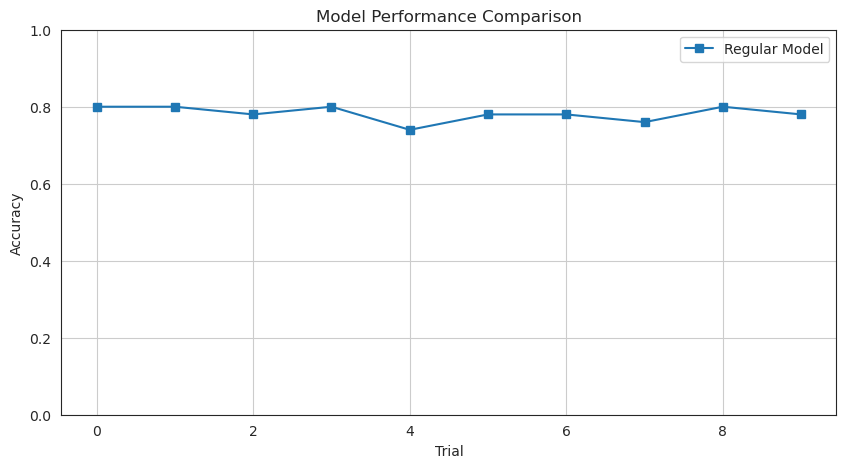

In [ ]:
def plot_performance(reg):
    # Plot accuracy per trial
    plt.figure(figsize=(10, 5))
    plt.plot(reg, 's-', label='Regular Model')
    # plt.plot(res_reg, 's-', label=' Model')
    plt.xlabel('Trial')
    plt.ylabel('Accuracy')
    plt.title('Model Performance Comparison')
    plt.ylim(0, 1)
    plt.legend()
    plt.grid(True)
    plt.show()

plot_performance(reg)
    

## Learn phases from features (classical features for now)

2025-07-10 11:57:25.646616: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1752141445.722613   12437 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1752141445.737148   12437 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1752141445.944267   12437 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1752141445.944289   12437 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1752141445.944291   12437 computation_placer.cc:177] computation placer alr

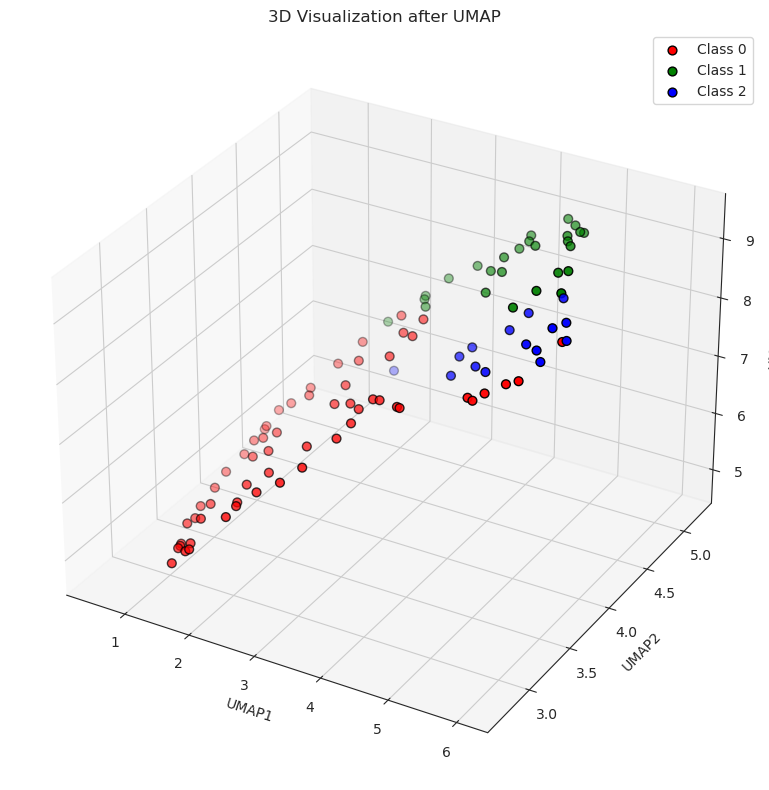

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import umap
from sklearn.datasets import make_blobs
from mpl_toolkits.mplot3d import Axes3D  # for 3D plotting

# Step 1: Generate synthetic 2D data with 3 classes
# X, y = X, Y  # assuming you've already created X and Y using make_blobs or similar

# Step 2: Apply UMAP to reduce to 3D
reducer = umap.UMAP(n_components=5, n_neighbors=15, min_dist=0.1, metric='euclidean', random_state=42)
X_umap = reducer.fit_transform(X)

# Step 3: Plot in 3D
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

colors = ['r', 'g', 'b']
for i in range(3):
    ax.scatter(
        X_umap[Y == i, 0],
        X_umap[Y == i, 1],
        X_umap[Y == i, 2],
        c=colors[i],
        label=f'Class {i}',
        s=40,
        edgecolor='k'
    )

ax.set_title("3D Visualization after UMAP")
ax.set_xlabel("UMAP1")
ax.set_ylabel("UMAP2")
ax.set_zlabel("UMAP3")
ax.legend()
plt.tight_layout()
plt.show()


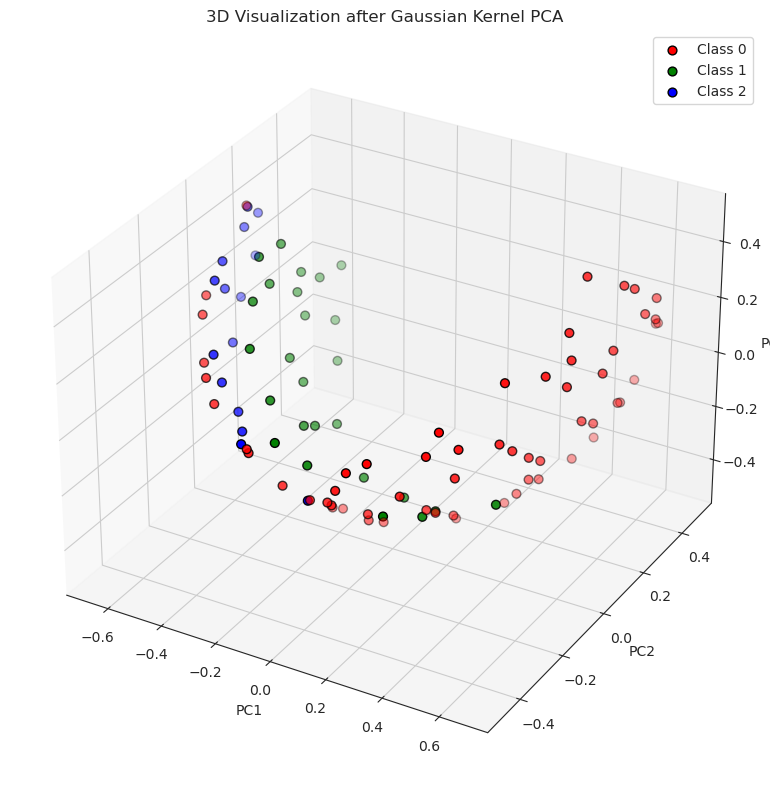

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.decomposition import KernelPCA
from mpl_toolkits.mplot3d import Axes3D  # for 3D plotting

# Step 1: Generate synthetic 2D data with 3 classes
# X, y = X, Y

# Step 2: Apply Kernel PCA 
kpca = KernelPCA(n_components=6, kernel='rbf', gamma=0.2)
X_kpca = kpca.fit_transform(X)

# Step 3: Plot in 3D
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

colors = ['r', 'g', 'b']
for i in range(3):
    ax.scatter(
        X_kpca[Y == i, 0],
        X_kpca[Y == i, 1],
        X_kpca[Y == i, 2],
        c=colors[i],
        label=f'Class {i}',
        s=40,
        edgecolor='k'
    )

ax.set_title("3D Visualization after Gaussian Kernel PCA")
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")
ax.legend()
plt.tight_layout()
plt.show()


In [ ]:
# X_kpca_data = pd.DataFrame(X_kpca)

# X_pi_data = pd.DataFrame(X_umap)
X_pi_data = pd.DataFrame(X_kpca)

In [ ]:
X_pi_train, Y_pi_train = X_pi_data[:N_train], Y[:N_train]
X_pi_test, Y_pi_test = X_pi_data[N_train:], Y[N_train:]
X_pi_train.shape, Y_pi_train.shape


((50, 6), (50,))

In [ ]:
reg_pi = model_estimation(X_pi_train, Y_pi_train, X_pi_test, Y_pi_test)

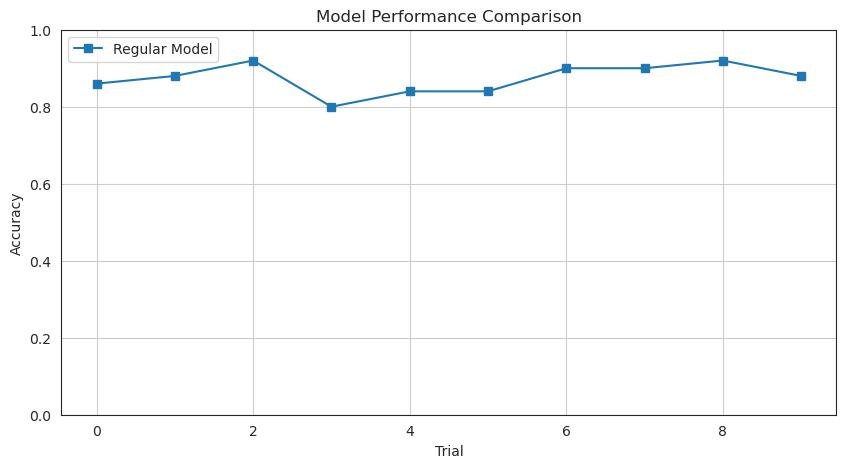

In [ ]:
plot_performance(reg_pi)

## Train Distillation LUPI

In [ ]:
epochs=50
criterion = torch.nn.CrossEntropyLoss()

priv=[]
reg=[]
dist=[]
t=0.6
l=1

# Fix later!!

X_kpca_train, Y_kpca_train = X_pi_data[:N_train], Y[:N_train]
X_kpca_test, Y_kpca_test =  X_pi_data[N_train:], Y[N_train:]


for rep in range(10):

    n_features = X_train.shape[1]
    m_labels = Y_train.unique().size
    x_tr = Variable(torch.from_numpy(X_train.values)).type(torch.FloatTensor)
    y_tr = Variable(torch.from_numpy(Y_train.values)).long()
    x_te = Variable(torch.from_numpy(X_test.values)).type(torch.FloatTensor)
    y_te = Variable(torch.from_numpy(Y_test.values)).long()

    n_pi_features = X_pi_train.shape[1]
    m_pi_labels = Y_train.unique().size
    xs_tr = Variable(torch.from_numpy(X_pi_train.values)).type(torch.FloatTensor)
    xs_te = Variable(torch.from_numpy(X_pi_test.values)).type(torch.FloatTensor)

    """
    Training of privilag space model
    """
    mlp_priv = Net(n_pi_features, m_pi_labels)
    optimizer = optim.RMSprop(mlp_priv.parameters())
    mlp_priv=fitModel(mlp_priv,optimizer,criterion,epochs,xs_tr,y_tr) 
    mlp_priv.eval()
    
    output = mlp_priv(xs_te)
    p_tr = mlp_priv(xs_tr)
    pred_priv = torch.argmax(output, 1).numpy()
    res_priv = np.mean(pred_priv == y_te.numpy())

    """
    Training of Input space model
    """
    mlp_reg = Net(n_features, m_labels)
    optimizer = optim.RMSprop(mlp_reg.parameters())
    mlp_reg = fitModel(mlp_reg, optimizer, criterion, epochs, x_tr, y_tr)
    mlp_reg.eval()
    output = mlp_reg(x_te)
    pred_reg = torch.argmax(output, 1).numpy()
    res_reg = np.mean(pred_reg == y_te.numpy())

    reg.append(res_reg)
    priv.append(res_priv)

    ### freezing layers
    for param in mlp_priv.parameters():
        param.requires_grad = False

    """
    LUPI Combination of two model
    """
    mlp_dist = Net(n_features, m_labels)
    optimizer = optim.RMSprop(mlp_dist.parameters())
    for epoch in range(100):
        y_pred = mlp_dist(x_tr)
        loss = criterion(y_pred, y_tr) + torch.exp(-t * criterion(p_tr, y_tr)) * (
            criterion(y_pred, torch.argmax(p_tr, 1).long()) - criterion(y_pred, y_tr)
        )
        optimizer.zero_grad()
        loss.backward(retain_graph=True)
        optimizer.step()
    mlp_dist.eval()
    output = mlp_dist(x_te)
    pred_dist = torch.argmax(output, dim=1).numpy()
    res_dis = np.mean(pred_dist == y_te.numpy())
    dist.append(res_dis)
    # print(res_priv, res_reg, res_dis)
    #pred = output > 0.5
    print('**** Step ', rep, '****')

#pred = output > 0.5
print(np.mean(priv),np.mean(reg),np.mean(dist))

**** Step  0 ****
**** Step  1 ****
**** Step  2 ****
**** Step  3 ****
**** Step  4 ****
**** Step  5 ****
**** Step  6 ****
**** Step  7 ****
**** Step  8 ****
**** Step  9 ****
0.8880000000000001 0.78 0.7860000000000001


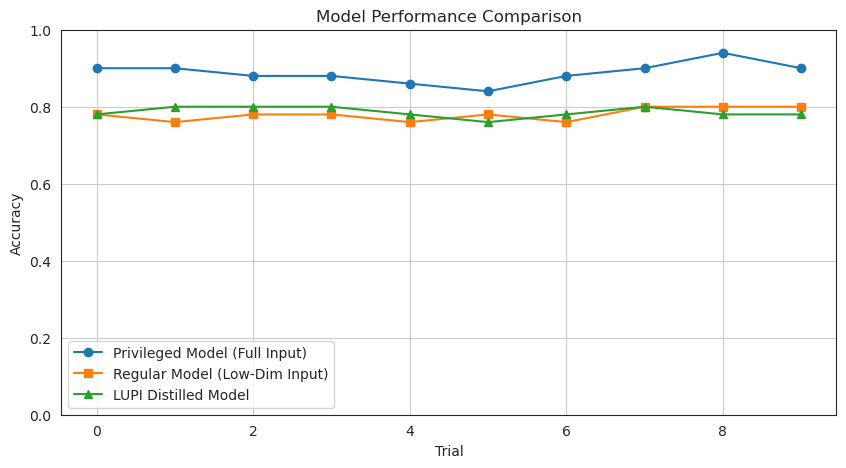

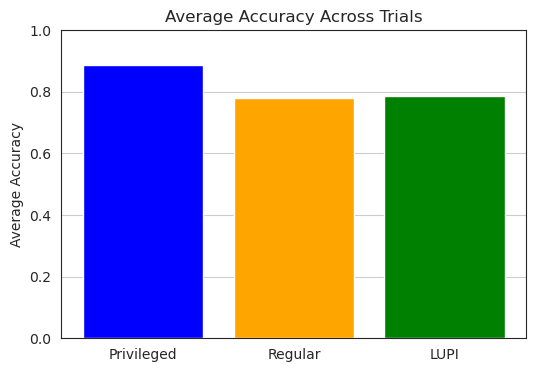

In [ ]:
# Convert to NumPy for easier plotting
priv = np.array(priv)
reg = np.array(reg)
dist = np.array(dist)

# Plot accuracy per trial
plt.figure(figsize=(10, 5))
plt.plot(priv, 'o-', label='Privileged Model (Full Input)')
plt.plot(reg, 's-', label='Regular Model (Low-Dim Input)')
plt.plot(dist, '^-', label='LUPI Distilled Model')
plt.xlabel('Trial')
plt.ylabel('Accuracy')
plt.title('Model Performance Comparison')
plt.ylim(0, 1)
plt.legend()
plt.grid(True)
plt.show()

# Bar plot of average performance
plt.figure(figsize=(6, 4))
means = [np.mean(priv), np.mean(reg), np.mean(dist)]
plt.bar(['Privileged', 'Regular', 'LUPI'], means, color=['blue', 'orange', 'green'])
plt.ylabel('Average Accuracy')
plt.title('Average Accuracy Across Trials')
plt.ylim(0, 1)
plt.grid(True, axis='y')
plt.show()

In [ ]:
means

[np.float64(0.8880000000000001),
 np.float64(0.78),
 np.float64(0.7860000000000001)]

In [ ]:
    mlp_reg = Net(49,10)
    optimizer = optim.RMSprop(mlp_reg.parameters())
    mlp_reg=fitModel(mlp_reg,optimizer,criterion,epochs,x_tr,y_tr) 
    mlp_reg.eval()
    output=mlp_reg(x_te)
    pred = torch.argmax(output,1)
    pred = pred.numpy()
    res_reg=np.mean(pred==y_te)  
    reg.append(res_reg)
    priv.append(res_priv)
    
    ### freezing layers
    for param in mlp_priv.parameters():
        param.requires_grad =False


    """
    Training of privilag space model
    """
    mlp_priv = Net(784,10)
    optimizer = optim.RMSprop(mlp_priv.parameters())
    mlp_priv=fitModel(mlp_priv,optimizer,criterion,epochs,xs_tr,y_tr) 
    mlp_priv.eval()
    output=mlp_priv(xs_te)
    p_tr = mlp_priv(xs_tr)


    pred = torch.argmax(output,1)
    pred=pred.numpy()
    res_priv=np.mean(pred==y_te) 


def model_estimation(X_train, Y_train, X_test, Y_test):

    reg_priv=[]

    for _ in range(10):
        n_features = X_train.shape[1]
        m_labels = Y_train.unique().size
        x_tr = Variable(torch.from_numpy(X_train.values)).type(torch.FloatTensor)
        y_tr = Variable(torch.from_numpy(Y_train.values)).long()

        x_te = Variable(torch.from_numpy(X_test.values)).type(torch.FloatTensor)
        y_te = Variable(torch.from_numpy(Y_test.values)).long()

        """
        Training of Input space model
        """
        mlp_reg = Net(n_features,m_labels)
        optimizer = optim.RMSprop(mlp_reg.parameters())
        mlp_reg = fitModel(mlp_reg,optimizer,criterion,epochs,x_tr,y_tr) 
        mlp_reg.eval()
        output=mlp_reg(x_te)
        pred = torch.argmax(output,1)
        pred = pred.numpy()
        # res_reg=np.mean(pred==y_te)
        res_reg = np.mean(pred == y_te.numpy())  
        reg.append(res_reg)
    return  np.array(reg)

def train_lupi(X_train, Y_train, X_test, Y_test, p_priv):

    n_features = X_train.shape[1]
    m_labels = Y_train.unique().size
    x_tr = Variable(torch.from_numpy(X_train.values)).type(torch.FloatTensor)
    y_tr = Variable(torch.from_numpy(Y_train.values)).long()

    x_te = Variable(torch.from_numpy(X_test.values)).type(torch.FloatTensor)
    y_te = Variable(torch.from_numpy(Y_test.values)).long()

    """
    LUPI Combination of two model
    """
    
    mlp_dist = Net(49,10)
    # best is 0.02 learning rate
    optimizer = optim.RMSprop(mlp_dist.parameters())
    # Training loop
    for _ in range(100):
            # Forward pass: Compute predicted y by passing x to the model
        y_pred= mlp_dist(x_tr)
        loss = criterion(y_pred,y_tr) + torch.exp(-t*criterion(p_tr,y_tr))*(criterion(y_pred,torch.argmax(p_tr,1).long()) - criterion(y_pred,y_tr))
        # Zero gradients, perform a backward pass, and update the weights.
        optimizer.zero_grad()
        loss.backward(retain_graph=True)
        optimizer.step()
    mlp_dist.eval()
    output=mlp_dist(x_te)
    pred = torch.argmax(output,dim=1)
    pred = pred.numpy()
    res_dis=np.mean(pred==y_te)
    dist.append(res_dis)

IndentationError: expected an indented block after function definition on line 33 (3932358133.py, line 35)

Accuracy after Kernel PCA: 0.83


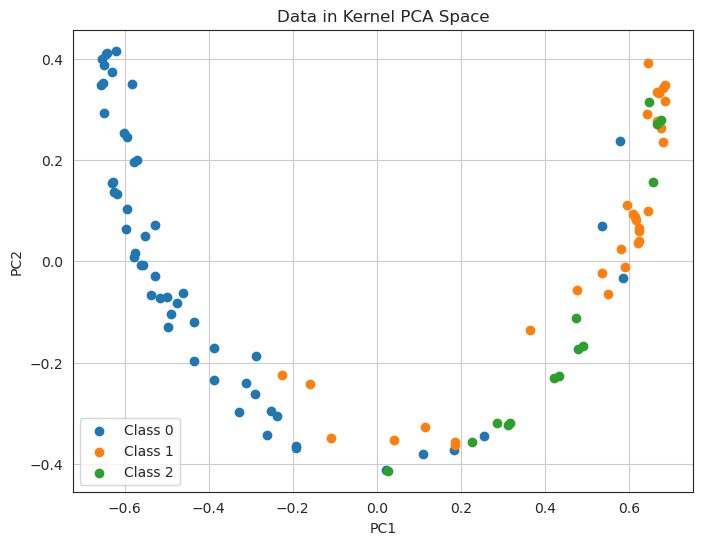

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.decomposition import KernelPCA
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

# Step 1: Create synthetic 2D data with 3 classes
from sklearn.datasets import make_blobs
# X, y = make_blobs(n_samples=300, centers=3, n_features=2, random_state=42)

# Step 2: Apply Gaussian (RBF) Kernel PCA
kpca = KernelPCA(n_components=3, kernel='rbf', gamma=0.2)
X_kpca = kpca.fit_transform(X)

# Step 3: Split into train/test sets
X_train, X_test, y_train, y_test = train_test_split(X_kpca, Y, test_size=0.3, random_state=42)

# Step 4: Fit a classifier (SVM)
clf = SVC(kernel='linear')
clf.fit(X_train, y_train)

# Step 5: Evaluate the model
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy after Kernel PCA: {accuracy:.2f}")

# Step 6: Visualize the transformed space
plt.figure(figsize=(8, 6))
for i in range(3):
    plt.scatter(X_kpca[Y == i, 0], X_kpca[Y == i, 1], label=f"Class {i}")
plt.title("Data in Kernel PCA Space")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend()
plt.grid(True)
plt.show()
